In [4]:
%pylab inline

import os
import pandas as pd

RESDIR = "/storage/mlamkin/projects/eSTR-MPRA-analysis/amplification_validation/bam_analysis/oligos/default_bwa_params/100bp_leniency/"

RESDIR2 = "/storage/mlamkin/projects/eSTR-MPRA-analysis/amplification_validation/bam_analysis/round1/updated_bwa_params/100bp_leniency/"
RESDIR3 = "/storage/mlamkin/projects/eSTR-MPRA-analysis/amplification_validation/bam_analysis/round2/updated_bwa_params/100bp_leniency/"

libs = ["1epcr-hifi_S4","1epcr-reg_S3","1ppcr-hifi_S2","1ppcr-reg_S1","2epcr-hifi_S10",
       "2epcr-reg_S9","2hpcr-hifi_S8","2hpcr-reg_S7","2ppcr-hifi_S6","2ppcr-reg_S5",
       "new-mid_S7", "old-mid_S3"]

meta = pd.read_csv("/storage/mlamkin/projects/eSTR-data/labels_for_bam_analysis.txt", sep="\t")

libacc = {}
libacc_off1 = {}
libnum = {}

for lib in libs:
    print("##########################")
    print(lib)
    try:
        df = pd.read_csv(os.path.join(RESDIR, lib+"_aln_validation.txt"), sep="\t")
    except:
        try:
            df = pd.read_csv(os.path.join(RESDIR2, lib+"_aln_validation.txt"), sep="\t")
        except:
            df = pd.read_csv(os.path.join(RESDIR3, lib+"_aln_validation.txt"), sep="\t")
    # Filter reads
    dff = df[(df["bp_after_str"]>10) & ((df["Observed_Start"]-df["True_Start"]).apply(abs)<=10)].copy()
    dff["match"] = (dff["Observed_Diff"]==dff["True_Diff"]).apply(int) # strict equals
    dff["match1"] = dff.apply(lambda x: int(abs(x["Observed_Diff"]-x["True_Diff"])<=len(x["Motif"])),1) # allow off by one

    
    # Collapse info per tag
    res = dff.groupby(["Chrom","True_Start","Tag","True_Diff"], as_index=False).agg({"UMI": len, "match": sum, "match1": sum})
    res = res[res["UMI"]>= 10]
    res["good"] = res.apply(lambda x: x["match"]*1.0/x["UMI"] > 0.50, 1)
    res["good1"] = res.apply(lambda x: x["match1"]*1.0/x["UMI"] > 0.50, 1)

    # Merge with metadata
    res = pd.merge(res, meta[meta["Oligo_Type"]!="Fun"], on=["Chrom","Tag"])
    res["STR_pos"] = res["STR_pos"].apply(int)
    res["STR_end"] = res["STR_end"].apply(int)
    res["Repeat_Number"] = res["Repeat_Number"].apply(int)
    res["RepeatLen"] = res.apply(lambda x: (x["STR_end"]-x["STR_pos"]+1)+x["Repeat_Number"], 1)
    res["MotifLen"] = res["Motif"].apply(len)
    
    # Overall
    print(np.mean(res["good"]))
    print(len(set(res["Tag"])))
    
    libn = lib.split("_")[0][1:]

    if libn not in libacc: libacc[libn] = []
    libacc[libn].append(np.mean(res["good"]))

    if libn not in libacc_off1: libacc_off1[libn] = []
    libacc_off1[libn].append(np.mean(res["good1"]))
    
    if libn not in libnum: libnum[libn] = []
    libnum[libn].append(len(set(res["Tag"])))

Populating the interactive namespace from numpy and matplotlib
##########################
1epcr-hifi_S4
0.898961937716263
1445
##########################
1epcr-reg_S3
0.6830409356725147
1710
##########################
1ppcr-hifi_S2
0.8556149732620321
1496
##########################
1ppcr-reg_S1
0.6152450090744102
1653
##########################
2epcr-hifi_S10
0.8535502958579881
2028
##########################
2epcr-reg_S9
0.6225366346639717
1979
##########################
2hpcr-hifi_S8
0.8869880767236911
1929
##########################
2hpcr-reg_S7
0.6863741339491917
2165
##########################
2ppcr-hifi_S6
0.8751224289911851
2042
##########################
2ppcr-reg_S5
0.6756107328794554
2497
##########################
new-mid_S7
0.4949793266391022
1693
##########################
old-mid_S3
0.49167180752621836
1621


In [14]:
libacc_off1

{'epcr-hifi': [0.9993079584775086, 0.997534516765286],
 'epcr-reg': [0.991812865497076, 0.9878726629610914],
 'ppcr-hifi': [0.9986631016042781, 0.9990205680705191],
 'ppcr-reg': [0.9879007864488808, 0.9883860632759311],
 'hpcr-hifi': [0.9994815966822188],
 'hpcr-reg': [0.9921478060046189],
 'ew-mid': [0.8623744831659775],
 'ld-mid': [0.8550277606415793]}

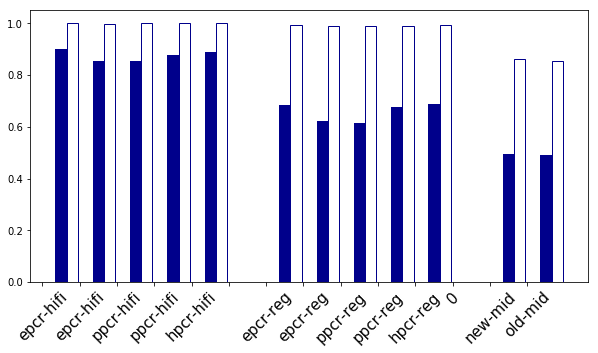

In [24]:
accvals = libacc["epcr-hifi"]+libacc["ppcr-hifi"]+libacc["hpcr-hifi"] + [0] + \
    libacc["epcr-reg"]+libacc["ppcr-reg"]+libacc["hpcr-reg"] + \
    [0] + \
    libacc["ew-mid"] + libacc["ld-mid"]

accvals1 = libacc_off1["epcr-hifi"]+libacc_off1["ppcr-hifi"]+libacc_off1["hpcr-hifi"] + [0] + \
    libacc_off1["epcr-reg"]+libacc_off1["ppcr-reg"]+libacc_off1["hpcr-reg"] + \
    [0] + \
    libacc_off1["ew-mid"] + libacc_off1["ld-mid"]

labels = ["epcr-hifi"]*2 + ["ppcr-hifi"]*2 + ["hpcr-hifi"] + [""] + \
["epcr-reg"]*2 + ["ppcr-reg"]*2 + ["hpcr-reg"] + [0] + \
["new-mid","old-mid"]

fig = plt.figure()
fig.set_size_inches((10, 5))
ax = fig.add_subplot(111)
ax.bar(range(len(accvals)), accvals, width=0.3, color="darkblue")
ax.bar([item+0.3 for item in range(len(accvals))], accvals1, width=0.3, color="white", edgecolor="darkblue")

ax.set_xticks([item-0.5 for item in range(len(accvals))])
ax.set_xticklabels(labels, rotation=45, size=15)

fig.savefig("mpra_prelim_acc.pdf")

In [33]:
dff.groupby(["Chrom","True_Start","Tag","True_Diff"], as_index=False).agg({"UMI": len, "match": sum, "match1": sum})
res = dff.groupby(["Chrom","True_Start","Tag","True_Diff"], as_index=False).agg({"UMI": len, "match": sum, "match1": sum})
res = res[res["UMI"]>= 10]
res["good"] = res.apply(lambda x: x["match"]*1.0/x["UMI"] > 0.50, 1)
res[res["True_Diff"]==0]

,Chrom,True_Start,Tag,True_Diff,UMI,match,match1,good
1,chr1,1323888,ATCAGAATTA,0,22,10,20,False
9,chr1,1323888,TTACTGTCGC,0,11,0,10,False
10,chr1,1437520,ACCCTGCGAA,0,12,5,8,False
16,chr1,1437520,CAGACGATGC,0,14,11,12,True
19,chr1,1437520,GGAGCCTTAA,0,12,7,9,True
...,...,...,...,...,...,...,...,...
2311,chr9,35854578,CATATAGTAA,0,91,41,67,False
2317,chr9,35854578,GTGGAGGAGC,0,33,20,33,True
2341,chr9,114230910,ATGAACCCTA,0,14,10,13,True
2344,chr9,114230910,CTTAAACCGG,0,71,40,58,True
